# Autoencoder and Variational Autoencoder (MNIST example)
In this notebook, we'll be building an autoencoder trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

Let's first import packages and load data

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and testing datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.70MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Visualize the data

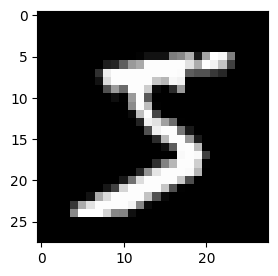

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Autoencoder

Now, let's build and train Autoencoder.


We first define some helper functions for plotting.

In [5]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [8]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
model

AutoEncoder(
  (encoder): Linear(in_features=784, out_features=64, bias=True)
  (decoder): Linear(in_features=64, out_features=784, bias=True)
)

Why did we take 784 as input dimension? This is because each image has size 28*28.

In [9]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            output = model(data)
            loss = loss_fn(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [10]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.122692
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.049788
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.033869
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.030195
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.025777
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.023809
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.021400
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.022506
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.019690
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.019529
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.018166
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.017612
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.018099
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.018614
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.017102
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.016733
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.016232
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.017900
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.015573
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.016661
Train Epoch:

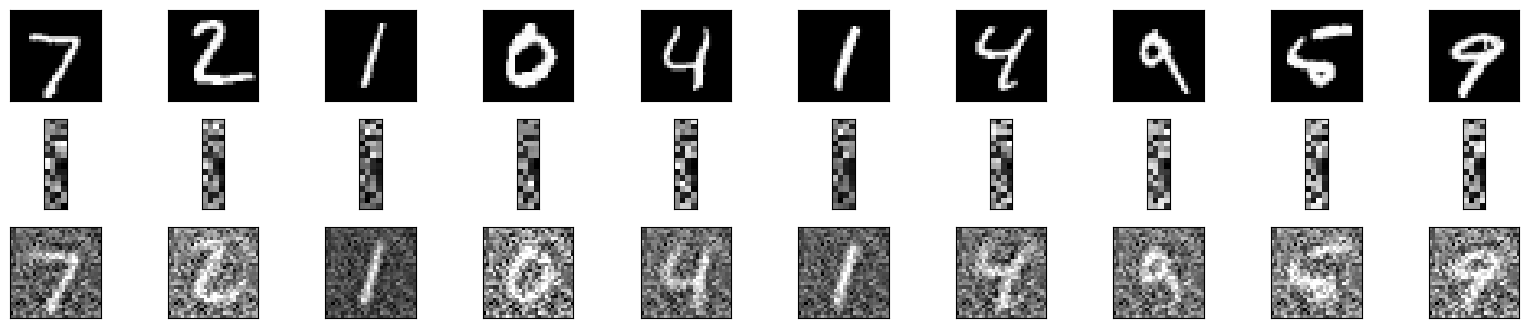

In [11]:
plot_reconstructions(model)

Note that the above encoder compresses the original 784-dim data to 64-dim latent vector, a compression factor of 12.25.

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again. In this particular case the compression factor is 12.25, we start with a 28x28(htxwd) image and it get compressed to a latent vector of dimension 64.

## Autoencoder with MLP

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and the third one of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [12]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            #TODOs: define the MLP for encoder
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),

        )

        #TODOs: define the MLP for decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [14]:
model

DeepAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [15]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.111184
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.054532
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.037738
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.035833
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.031373
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.028711
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.025983
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.026821
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.024087
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.024215
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.023203
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.022395
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.022065
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.023446
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.021391
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.020869
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.019725
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.021222
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.019490
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.019608
Train Epoch:

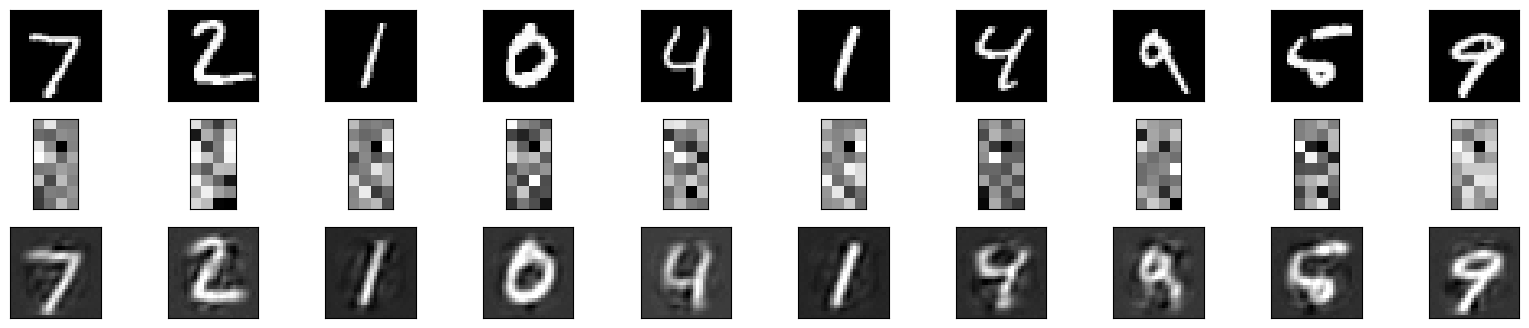

In [16]:
plot_reconstructions(model)

We can see that with deep autoencoder and decoder, we achieve better reconstruction, even with 32-dimensional latent vector. However, the reconstructed picture is a bit blurred.

To get a clear reconstruction, let's replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`, which is often used for classification problem. Here  using the `BCEWithLogitsLoss` encourages the model to take values close to 0 and 1, thus sharpening the reconstructed images.

In [17]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694296
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.268119
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.219825
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.241030
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.199393
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.191319
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.167033
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.165651
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.158645
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.153137
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.150357
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.147970
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.139426
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.149726
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.144057
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.142911
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.133123
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.138379
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.129858
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.133378
Train Epoch:

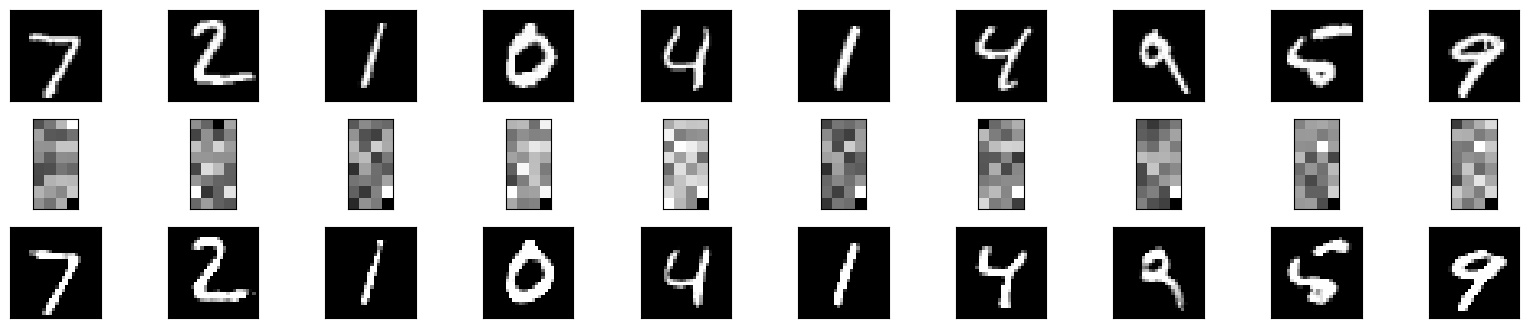

In [ ]:
plot_reconstructions(model)

## Interpolation on Latent Space

You may wonder why do we even use an autoencoder? It seems that we just map the original image to a low-dimensional latent vector and map it back! It turns out we can do a lot of interesting operations on the latent space (for example, diffusion). If we directly operate on the original image in pixel space, this means processing a LOT of data, and  make high-resolution generation very computationally expensive.  Instead, we operate on the latent space, using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels.

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [18]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

In [19]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [20]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1

In [21]:
decoded_imgs = model.decoder(interp)

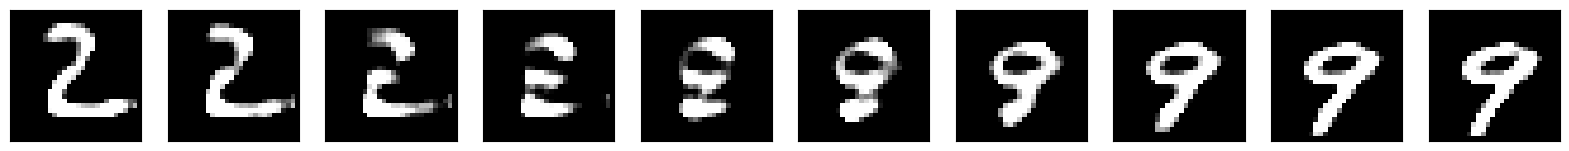

In [22]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)

    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

In [24]:
import matplotlib.animation as animation

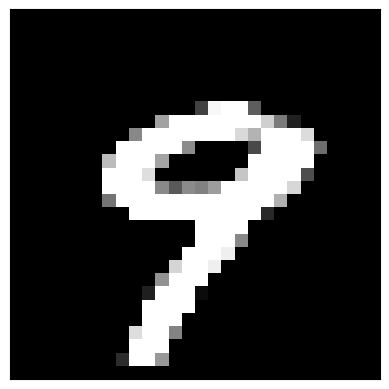

In [25]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
writergif = animation.PillowWriter(fps=30)
ani.save("AE_interpolate.gif",writer=writergif)
plt.show()

---
# Denoising Autoencoder


Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='https://github.com/RankJay/Deep-Learning-with-Pytorch-from-Facebook-Udacity/blob/master/Autoencoder/denoising-autoencoder/notebook_ims/autoencoder_denoise.png?raw=1' width=70%/>


Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. Similar ideas are also used in diffusion models to denoise noisy images iteratively.

>**We'll use noisy images as input and the original, clean images as targets.**

Below is an example of some of the noisy images I generated and the associated, denoised images.

<img src='https://github.com/RankJay/Deep-Learning-with-Pytorch-from-Facebook-Udacity/blob/master/Autoencoder/denoising-autoencoder/notebook_ims/denoising.png?raw=1' />


Since this is a harder problem for the network, we'll want to use _deeper_ convolutional layers here; layers with more feature maps. You might also consider adding additional layers. I suggest starting with a depth of 32 for the convolutional layers in the encoder, and the same depths going backward through the decoder.


Note that for the decoder layers, we will like to increase the spatial dimensions, so we will use [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). The idea is very similar to `nn.Conv2d`, but it increases the spatial dimension instead of decreasing. We will not cover this concept in class, but you can check [this](https://d2l.ai/chapter_computer-vision/transposed-conv.html) to understand this if you're interested.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        ## encoder layers ##
        # TODO: add convolution and pooling layers
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))

        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [27]:
model=model.to(device)

---
### Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [28]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        # send the data to the device
        images = images.to(device)
        noisy_imgs = noisy_imgs.to(device)

        #1. forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        #2. calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        #3. clear the gradients of all optimized variables
        optimizer.zero_grad()
        #4. backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #5. perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 4.257872
Epoch: 2 	Training Loss: 2.298763
Epoch: 3 	Training Loss: 2.033614
Epoch: 4 	Training Loss: 1.920393
Epoch: 5 	Training Loss: 1.846262
Epoch: 6 	Training Loss: 1.785506
Epoch: 7 	Training Loss: 1.739310
Epoch: 8 	Training Loss: 1.707628
Epoch: 9 	Training Loss: 1.675444
Epoch: 10 	Training Loss: 1.654628
Epoch: 11 	Training Loss: 1.634193
Epoch: 12 	Training Loss: 1.618960
Epoch: 13 	Training Loss: 1.605739
Epoch: 14 	Training Loss: 1.592831
Epoch: 15 	Training Loss: 1.583258
Epoch: 16 	Training Loss: 1.573858
Epoch: 17 	Training Loss: 1.560781
Epoch: 18 	Training Loss: 1.554456
Epoch: 19 	Training Loss: 1.546947
Epoch: 20 	Training Loss: 1.538338


### Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

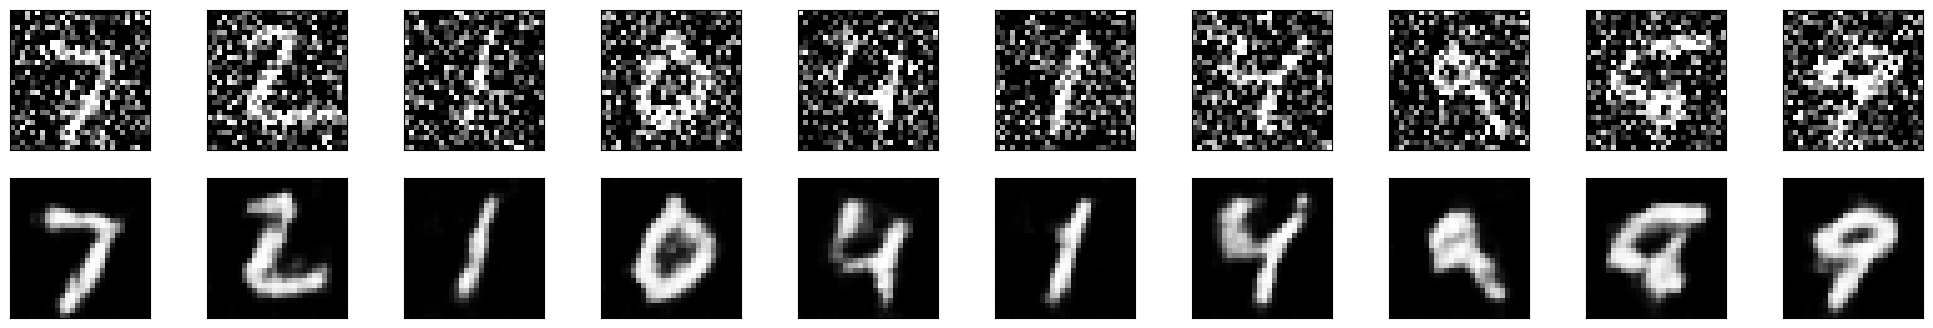

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

noisy_imgs=noisy_imgs.to(device)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(-1, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

---
# Variational Autoencoder (VAE)


In autoencoders, the input data is mapped into a fixed latent representation. This is particularly useful when we aim to train models to compress data or generate *deterministic* predictions. In contrast, a variational autoencoder (VAE) converts the input data to a Gaussian distribution with mean vector $\mu$ and log variance vector $\log(\sigma^2)$.

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/leaky_relu.png?raw=true' width=40% />

If you stare this figure closely enough, you'll see that there is a small negative ouput for negative input values. The negative slope is 0.01 by default.


## Define our model

We first build the encoder. Note that here encoder produces two vectors, one for mean and the other for log of variance.

In [90]:
class VAE_Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_Encoder, self).__init__()

        self.FC_1 = nn.Linear(input_dim, hidden_dim)
        self.FC_2 = nn.Linear(hidden_dim, hidden_dim)

        #Todo: Add the layers for mean and log variance of dimension latent_dim
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_logvar   = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_1(x))
        h_       = self.LeakyReLU(self.FC_2(h_))
        # encoder produces mean and log of variance
        mean     = self.FC_mean(h_)
        log_var  = self.FC_logvar(h_)

        return mean, log_var

Next, we build the decoder, which converts a latent vector back to the original image.

In [91]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAE_Decoder, self).__init__()

        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


Finally, we define the entire VAE model with the encoder and decoder. Note that the latent vector is sampled from the Gaussian distribution with given mean and standard deviation.

In [92]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder

    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(mean).to(device)        # sampling standard Gaussian vector epsilon
        # reparameterization trick
        # TODO: define z following Gaussian distribution with given mean and standard deviation
        # hint: (exp(0.5*log var) -> std)
        z = mean + torch.exp(0.5 * log_var)*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decoder(z)

        return x_hat, mean, log_var

In [93]:
input_dim = 784
hidden_dim=256
latent_dim=2

In [104]:
encoder = VAE_Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = VAE_Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = input_dim)
model = VAE(Encoder=encoder, Decoder=decoder).to(device)
model

VAE(
  (encoder): VAE_Encoder(
    (FC_1): Linear(in_features=784, out_features=256, bias=True)
    (FC_2): Linear(in_features=256, out_features=256, bias=True)
    (FC_mean): Linear(in_features=256, out_features=2, bias=True)
    (FC_logvar): Linear(in_features=256, out_features=2, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): VAE_Decoder(
    (FC_hidden): Linear(in_features=2, out_features=256, bias=True)
    (FC_hidden2): Linear(in_features=256, out_features=256, bias=True)
    (FC_output): Linear(in_features=256, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [105]:
model=model.to(device)

## Train VAE

We are ready to train our VAE model.

First, we define the loss function.

In [106]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum') # here we use BCE loss instead of MSE loss
    #TODO: define the regularization term 0.5* (var -1 - log var + mean^2)
    regularization= 0.5 * torch.sum(log_var.exp() -1 - log_var + mean.pow(2)) # this is the regularization term
    return reproduction_loss + regularization

In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [108]:
epochs = 30
print("Start training VAE...")
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, input_dim).to(device)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  178.53404708096923
	Epoch 2 complete! 	Average Loss:  163.58886677223947
	Epoch 3 complete! 	Average Loss:  159.16727586744182
	Epoch 4 complete! 	Average Loss:  156.46583185022897
	Epoch 5 complete! 	Average Loss:  154.57054027447452
	Epoch 6 complete! 	Average Loss:  153.18721833936434
	Epoch 7 complete! 	Average Loss:  152.11506091008954
	Epoch 8 complete! 	Average Loss:  151.093926591578
	Epoch 9 complete! 	Average Loss:  150.33849077418114
	Epoch 10 complete! 	Average Loss:  149.62289559802988
	Epoch 11 complete! 	Average Loss:  148.97031826805025
	Epoch 12 complete! 	Average Loss:  148.62441320429488
	Epoch 13 complete! 	Average Loss:  148.00995064392416
	Epoch 14 complete! 	Average Loss:  147.70609196323977
	Epoch 15 complete! 	Average Loss:  147.3295433345701
	Epoch 16 complete! 	Average Loss:  146.97617180497568
	Epoch 17 complete! 	Average Loss:  146.67801316952375
	Epoch 18 complete! 	Average Loss:  146.4614964243951
	

## Generate new digits from the latent representations

Since we set the latent dimension to be $2$, all we need to generate an image from the latent space is two float numbers. Let’s generate some images from the latent space:

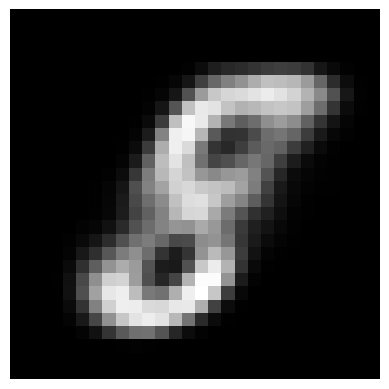

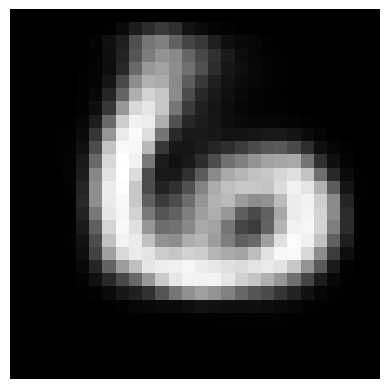

(None, None)

In [70]:
def generate_digit(z0, z1):
    z_sample = torch.tensor([[z0, z1]], dtype=torch.float).to(device)
    x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

Since the latent dimension is 2, we can plot the latent space in a two dimensional plane.

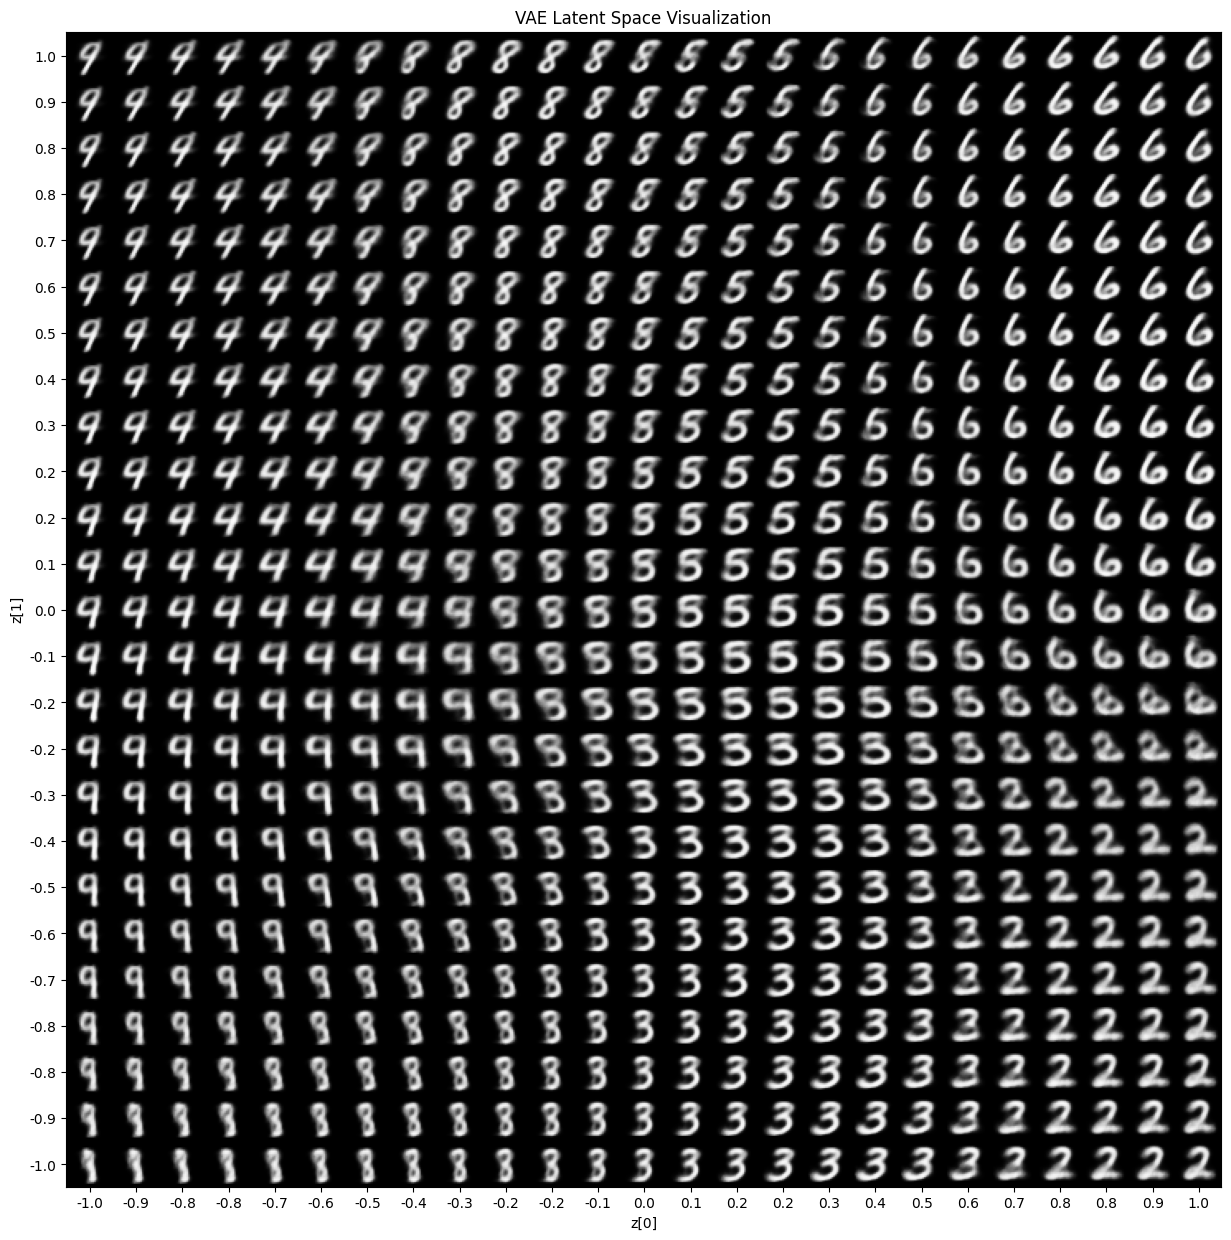

In [71]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

This is what the latent space looks like for mean and variance values between -1.0 and 1.0. What happens if we change this scale to -5.0 and 5.0?

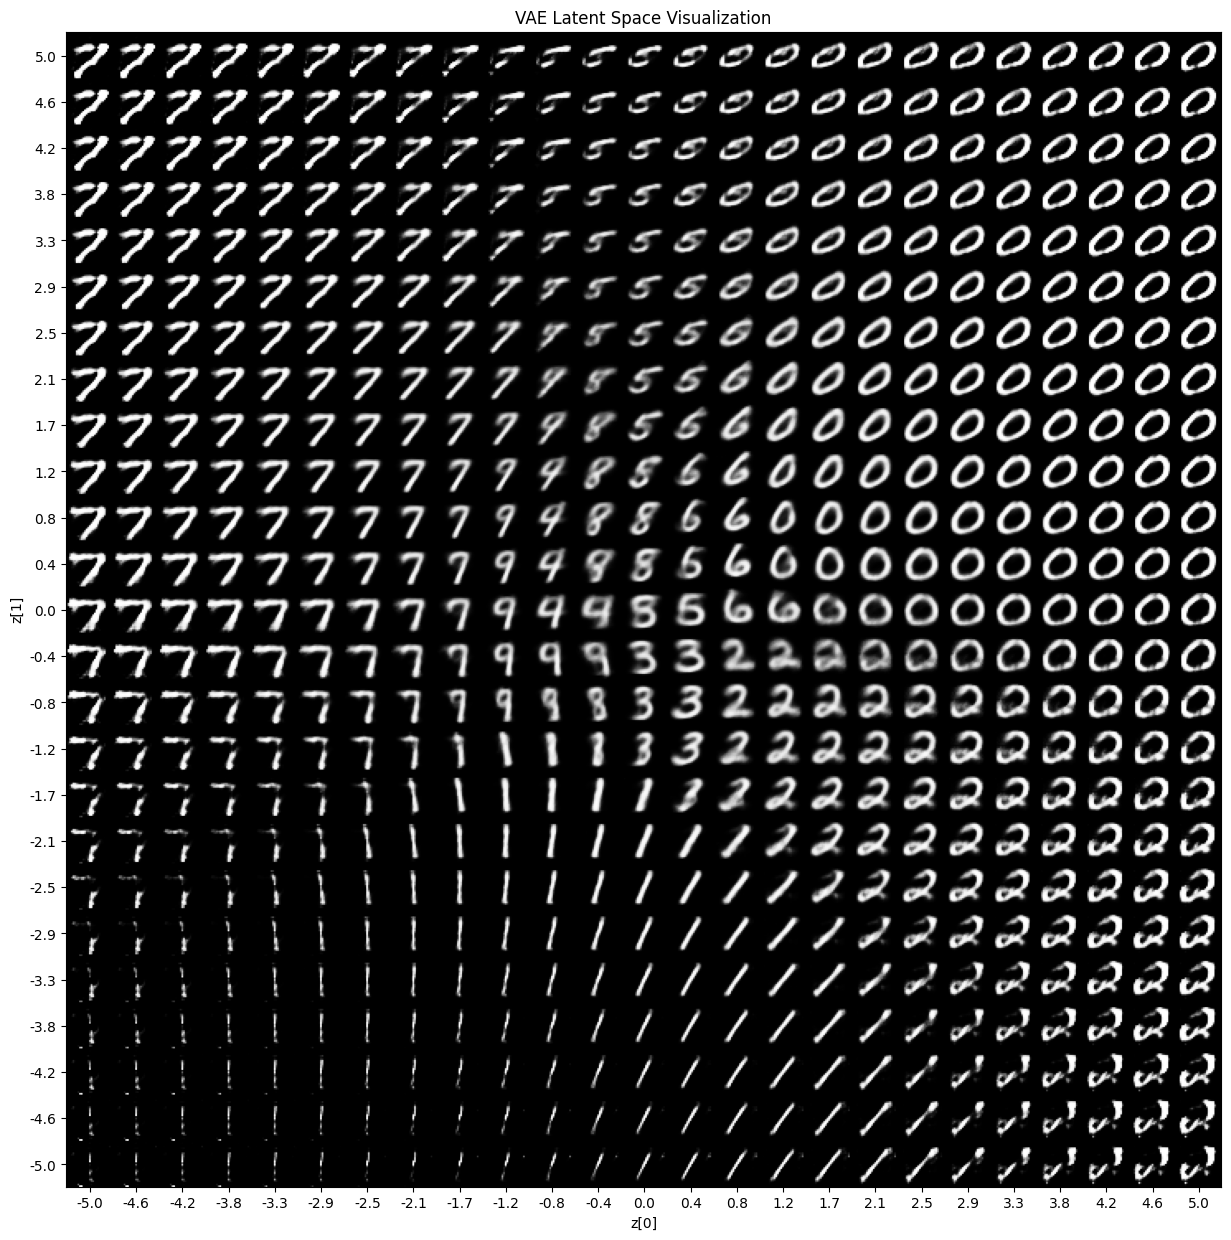

In [72]:
plot_latent_space(model, scale=5.0)

Again, interesting! We can now see the range that most digit representations lie within. Now, we know how to build a simple VAE from scratch, sample images and visualize the latent space. But VAEs do not end here, there are more advanced techniques that make representation learning even more fascinating.

## Well Done!

<img src="https://video.udacity-data.com/topher/2018/November/5be21b06_dancing-beemo/dancing-beemo.gif?raw=true" width=40%>